## Dependents

In [1]:
%pylab inline
import os, glob
import cPickle as pickle
home=os.getcwd()

path='/Users/yj/repo/vpsc/vpsc-dev-fld/'
os.chdir(path)
import fld,fld_pp
path='/Users/yj/repo/vpsc/vpsc-dev-yld/src/py_pack/yld_hah/'
os.chdir(path)
import lib_dat
os.chdir(home)


from glob import glob
import time
from MP import progress_bar, lib
from MP.lib import mpl_lib
import matplotlib as mpl
from MP.mat import mech
import scipy as sp
from scipy import integrate
from scipy import optimize
cf=optimize.curve_fit

intp=np.interp#  ## (x,xp,fp,left=None, right=None)

cumtrapz=sp.integrate.cumtrapz

fc=mech.FlowCurve
uet=progress_bar.update_elapsed_time
GS=mpl.gridspec.GridSpec
path_home = os.getcwd()
os.chdir('/Users/yj/repo/vpsc/vpsc-dev-fld')
import fld_pp, fld
from fld_pp import draw_guide


os.chdir('/Users/yj/repo/vpsc/vpsc-dev-yld/src/py_pack/yld_hah/')
import lib_dat
os.chdir(path_home)


def func_voce2(e,a=223,b0=236,b1=1148,c=1540):
    return a-b0*np.exp(-c*e)+b1*e
def lin0(e,a):
    return a*e
def lin1(e,a,a0):
    return a*e+a0
#def func_power(e,a=6.37,n=2.61):
def func_power(e,a,n):
    return a * e**n
def func_voce(e,s0=417,s1=119,ev_inv=15):
    return s0-(s0-s1)*np.exp(-ev_inv*e)
def func_swift(e,c=630,e0=-7.e-5,n=0.256):
    return c*(e+e0)**n


Populating the interactive namespace from numpy and matplotlib


## Necessary functions

In [2]:
def Fit_Err(func,popt,sigma):
    values = np.array([
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),
        
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),   
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
        
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
        
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),        

    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),  
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),
        
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),
    ])
    return np.std(values, axis=0)
    

In [3]:
def read_PF(fn):
    """
    Arguments
    ---------
    fn
    """
    dat=np.loadtxt(fn,skiprows=1).T
    # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye = dat    
    return dat    

def filt(d,evm_mx):
    ## ---
    ref=d[:,0] ## using Exx as reference
    ind=np.argsort(ref)
    dm = d[ind,:].T
    ex = dm[5]
    ey = dm[6]
    ez = -ex-ey

    evm = np.sqrt(2./3.*(ex**2+ey**2+ez**2))
    ##
    sx=dm[1]
    sy=dm[3]
    sz=np.zeros((len(sx),))
    p = (sx+sy+sz)/3.
    svm = np.sqrt(3./2.*((sx-p)**2+(sy-p)**2+(ez-p)**2))
    
    exr=dm[7];eyr=dm[8]
    sxr=dm[2];syr=dm[4]
    xerr=np.sqrt(2./3.*(exr**2+eyr**2))
    yerr=np.sqrt(3./2.*(sxr**2+syr**2))
    
    
    flt = evm<evm_mx
    ex  = ex[flt]
    ey  = ey[flt]
    ez  = ez[flt]
    sx  = sx[flt]
    sy  = sy[flt]
    evm = evm[flt]
    svm = svm[flt]
    
    exr = exr[flt]
    eyr = eyr[flt]
    sxr = sxr[flt]
    syr = syr[flt]
    
    return evm, svm, ex,ey,exr,eyr, sx,sy,sxr,syr

-- Load bulge experiment for comparison

In [4]:
## Load Pickled bulge data
f=open('../../pickles/IFsteel/bulge_exp','rb')
bulge_exp_dat=pickle.load(f)
f.close()

## Combine BB data and writh the sorted data to PF_raw_dat.txt

In [5]:
def main(dat_master,lab='BB',fig=None,c='r'):
    dat_master=np.array(dat_master)
    print dat_master.shape

    #1.
    ref=dat_master[:,0] ## using Exx as reference
    ind=np.argsort(ref)
    dm=dat_master[ind,:].T

    ex=dm[5];ey=dm[6];ez=-ex-ey
    evm = np.sqrt(2./3.*(ex**2+ey**2+ez**2))
    sx=dm[1];sy=dm[3];sz=np.zeros((len(sx),))
    p = (sx+sy+sz)/3.
    svm = np.sqrt(3./2.*((sx-p)**2+(sy-p)**2+(ez-p)**2))

    exr=dm[7];eyr=dm[8]
    sxr=dm[2];syr=dm[4]
    xerr=np.sqrt(2./3.*(exr**2+eyr**2))
    yerr=np.sqrt(3./2.*(sxr**2+syr**2))

    if fig==None:
        fig=plt.figure(figsize=(7,2.2))
        ax1=fig.add_subplot(131);ax2=fig.add_subplot(132);ax3=fig.add_subplot(133)
    else:
        ax1,ax2,ax3=fig.axes
    
    ax1.errorbar(evm,svm,xerr=xerr,yerr=yerr,
                 marker='.',color=c,ls='None',label='Marciniak')
    ax2.errorbar(sx,sy,sxr,sxr,color=c,ls='None')
    ax3.errorbar(ex,ey,exr,exr,color=c,ls='None')

    ax1.set_xlabel(r'$\mathrm{\bar{E}^{VM}}$')
    ax1.set_ylabel(r'$\mathrm{\bar{\Sigma}^{VM}}$  [MPa]')
    ax1.plot(bulge_exp_dat[0],bulge_exp_dat[1],c='k',label='Bulge')
    ax1.set_xlim(0.,0.8)
    #ax1.legend(loc='lower center',fontsize=9)

    for ax in fig.axes:
        lib_dat.tick_bin(ax)

    for i in xrange(len(fig.axes)-1):
        ax=fig.axes[i+1]
        ax.set_xlim(0,)
        ax.set_ylim(0.,)
        ax.set_aspect('equal')
        if i==0: 
            ax.set_xlim(0.,600);ax.set_ylim(0.,600)
            fld_pp.draw_guide(ax,max_r=2,r_line=[0,0.5,1,1.5,2])
        if i==1:
            ax.set_xlim(-0.1,0.12);ax.set_ylim(-0.1,0.12)

In [6]:
def main(dat_master,lab='BB',fig=None,c='r'):
    dat_master=np.array(dat_master)
    # print dat_master.shape

    #1.
    ref=dat_master[:,0] ## using Exx as reference
    ind=np.argsort(ref)
    dm=dat_master[ind,:].T

    ex=dm[5];ey=dm[6];ez=-ex-ey
    evm = np.sqrt(2./3.*(ex**2+ey**2+ez**2))
    sx=dm[1];sy=dm[3];sz=np.zeros((len(sx),))
    p = (sx+sy+sz)/3.
    svm = np.sqrt(3./2.*((sx-p)**2+(sy-p)**2+(ez-p)**2))

    exr=dm[7];eyr=dm[8]
    sxr=dm[2];syr=dm[4]
    xerr=np.sqrt(2./3.*(exr**2+eyr**2))
    yerr=np.sqrt(3./2.*(sxr**2+syr**2))

    if fig==None:
        fig=plt.figure(figsize=(7,2.2))
        ax1=fig.add_subplot(131);ax2=fig.add_subplot(132);ax3=fig.add_subplot(133)
    else:
        ax1,ax2,ax3=fig.axes
    
    ax1.errorbar(evm,svm,xerr=xerr,yerr=yerr,
                 marker='.',color=c,ls='None',label='Marciniak')
    ax2.errorbar(sx,sy,sxr,sxr,color=c,ls='None')
    ax3.errorbar(ex,ey,exr,exr,color=c,ls='None')

    ax1.set_xlabel(r'$\mathrm{\bar{E}^{VM}}$')
    ax1.set_ylabel(r'$\mathrm{\bar{\Sigma}^{VM}}$  [MPa]')
    ax1.plot(bulge_exp_dat[0],bulge_exp_dat[1],c='k',label='Bulge')
    ax1.set_xlim(0.,0.8)
    #ax1.legend(loc='lower center',fontsize=9)

    for ax in fig.axes:
        lib_dat.tick_bin(ax)

    for i in xrange(len(fig.axes)-1):
        ax=fig.axes[i+1]
        ax.set_xlim(0,)
        ax.set_ylim(0.,)
        ax.set_aspect('equal')
        if i==0: 
            ax.set_xlim(0.,600);ax.set_ylim(0.,600)
            fld_pp.draw_guide(ax,max_r=2,r_line=[0,0.5,1,1.5,2])
        if i==1:
            ax.set_xlim(-0.1,0.5);ax.set_ylim(-0.1,0.5)
            fld_pp.draw_guide(ax,max_r=900,r_line=[-0.5,0,1,2,2.5])


    
    plt.tight_layout()
    fig.savefig('marciniak_bulge_%s.pdf'%lab,bbox_inches='tight')
    return fig

## Application of main

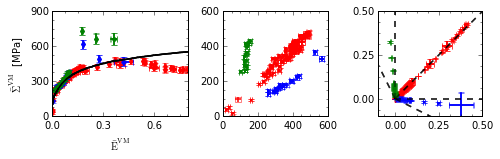

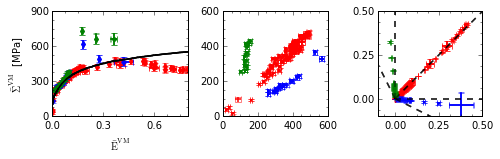

In [8]:
fns_BB=glob('/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/*/PF_raw_dat.txt')
fns_BB.sort()
dat_master_BB=[]
for i in xrange(len(fns_BB)):
    dat = read_PF(fns_BB[i]) # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye
    nstp = dat.shape[1]
    for j in xrange(nstp):
        dat_master_BB.append(dat[:,j])
dat_master_BB=np.array(dat_master_BB)
fig=main(dat_master_BB,'BB',c='r')


fns_BB=glob('/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20120713/PF_raw_dat.txt')
fns_BB.sort()
dat_master_PR=[]
for i in xrange(len(fns_BB)):
    dat = read_PF(fns_BB[i]) # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye
    nstp = dat.shape[1]
    for j in xrange(nstp):
        dat_master_PR.append(dat[:,j])
dat_master_PR=np.array(dat_master_PR)
fig=main(dat_master_PR,'PSRD',fig,c='b')

fns_BB=glob('/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20120717/PF_raw_dat.txt')
fns_BB.sort()
dat_master_PT=[]
for i in xrange(len(fns_BB)):
    dat = read_PF(fns_BB[i]) # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye
    nstp = dat.shape[1]
    for j in xrange(nstp):
        dat_master_PT.append(dat[:,j])
dat_master_PT=np.array(dat_master_PT)
main(dat_master_PT,'PSTD',fig,c='g')

- Filter

  BB    222.0    215.6   1224.9    969.0   --    222.1    187.4   1036.9    233.0 
PSRD    231.5   6776.3   1913.8   1922.3   --    112.4   7326.7   1072.6   1898.9 
PSTD    118.1    -22.2    229.3   3117.0   --    201.6    -55.5   2434.9     67.5 


/Users/yj/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


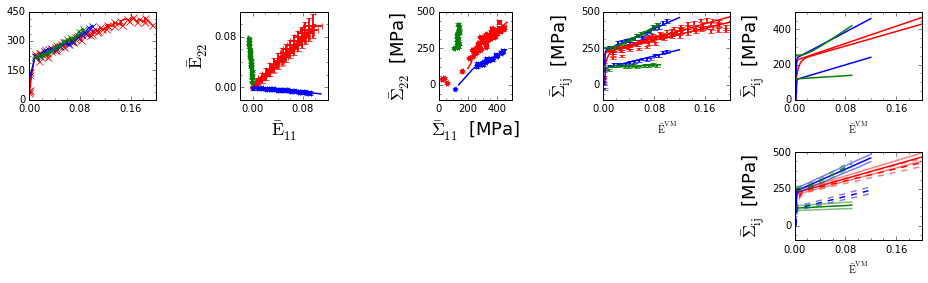

In [9]:
D=[dat_master_BB,dat_master_PR,dat_master_PT]
labs=['BB','PSRD','PSTD']
cs  =['r','b','g']
evm_mx=[0.2,0.12,0.09]


fig=plt.figure(figsize=(13,4))
ax1=fig.add_subplot(251);ax2=fig.add_subplot(252)
ax3=fig.add_subplot(253);ax4=fig.add_subplot(254)
ax5=fig.add_subplot(255);


ax10=fig.add_subplot(2,5,10)

numpy.seterr(all='raise')
             

myFCs=[]

for i in xrange(len(D)):
    d=D[i]
    lab=labs[i]
    emx=evm_mx[i]    
    evm, svm, ex, ey, exr, eyr, sx,sy,sxr,syr = filt(d,emx)
    l,=ax1.plot(evm,svm,'x-',color=cs[i])
    c=l.get_color()

    ## strain fit
    x_ref = np.linspace(0.0022,emx,100)
    x=evm; y1=ex; y2=ey
    func = lin0
    popt1_e,pcov1 = cf(func,x,y1)
    popt2_e,pcov2 = cf(func,x,y2)
    y1_fit_e, y2_fit_e = func(x_ref,*popt1_e), func(x_ref,*popt2_e)
    
    ## Stress fit
    x=evm; y1=sx; y2=sy
    func = func_voce2
    popt1_s,pcov1 = cf(func,x,y1)
    popt2_s,pcov2 = cf(func,x,y2)    
    y1_fit_s, y2_fit_s = func(x_ref,*popt1_s), func(x_ref,*popt2_s)    
    
    ## interpolate uncertainty    
    sxr_ = np.interp(x_ref,x,sxr)
    syr_ = np.interp(x_ref,x,syr)

    print '%4s '%lab,
    for j in xrange(len(popt1_s)):
        print '%7.1f '%popt1_s[j],
    print ' -- ',
    for j in xrange(len(popt2_s)):
        print '%7.1f '%popt2_s[j],
    print
    
    
    
    ## Below is plottings.
    ## Raw data
    ax2.errorbar(ex,ey,exr,eyr,'.',color=c,ls='None')
    ax3.errorbar(sx,sy,sxr,syr,'.',color=c,ls='None')    
    ax4.errorbar(x,y1,yerr=sxr,color=c,ls='None')
    ax4.errorbar(x,y2,yerr=syr,color=c,ls='None')
    
    ## strain fit
    ax2.plot(y1_fit_e,y2_fit_e,color=c)
    ## stress fit
    ax3.plot(y1_fit_s,y2_fit_s,color=c)    

    ## EVM vs. Sij plots
    ax4.plot(x_ref,y1_fit_s,color=c)
    ax4.plot(x_ref,y2_fit_s,color=c)
    ax5.plot(x_ref,y1_fit_s,color=c)
    ax5.plot(x_ref,y2_fit_s,color=c)
    
    ax10.plot(x_ref,func(x_ref,*popt1_s),color=c,ls='-')
    ax10.plot(x_ref,func(x_ref,*popt1_s)+sxr_*2,color=c,alpha=0.5,ls='-')
    ax10.plot(x_ref,func(x_ref,*popt1_s)-sxr_*2,color=c,alpha=0.5,ls='-')

    ax10.plot(x_ref,func(x_ref,*popt2_s),color=c,ls='--')
    ax10.plot(x_ref,func(x_ref,*popt2_s)+syr_*2,color=c,alpha=0.5,ls='--')
    ax10.plot(x_ref,func(x_ref,*popt2_s)-syr_*2,color=c,alpha=0.5,ls='--')
    
    

    
## Plot decos.
ax5.set_ylim(0.,)    
for ax in fig.axes:
    lib_dat.tick_bin(ax)
ax2.set_ylabel(r'$\mathrm{\bar{E}_{22}}$',fontsize=18)
ax2.set_xlabel(r'$\mathrm{\bar{E}_{11}}$',fontsize=18)
ax3.set_ylabel(r'$\mathrm{\bar{\Sigma}_{22}}$  [MPa]',fontsize=18)
ax3.set_xlabel(r'$\mathrm{\bar{\Sigma}_{11}}$  [MPa]',fontsize=18)
for ax in [ax4,ax5,ax10]:
    ax.set_xlabel(r'$\mathrm{\bar{E}^{VM}}$')
    ax.set_ylabel(r'$\mathrm{\bar{\Sigma}_{ij}}$  [MPa]',fontsize=18)
for ax in fig.axes[1:3]:
    ax.set_aspect('equal')
plt.tight_layout()

